In [98]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('../../Code/')
from testWN import testWN as twm
from wntr.metrics import economic

In [99]:
%matplotlib notebook

# Get Network Information

In [100]:
inp_file = '../../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)

nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Load Result File

In [101]:
with open('./tempResults/05_results_sim_time.pkl', 'rb') as f:
    results = pickle.load(f)

In [102]:
with open('/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/results_sim_0_noControls.pkl', 'rb') as f:
    ref = pickle.load(f)

# Pressure

<IPython.core.display.Javascript object>


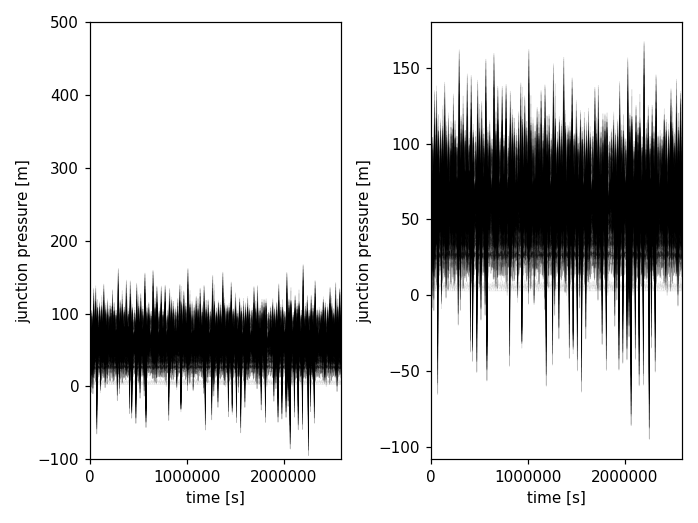

In [103]:
fig, ax = plt.subplots(1,2)
results.node['pressure'][node_names[2]].plot(legend=False, ax=ax[0], color='k', linewidth=0.5, alpha=0.1)
ax[0].set_ylim(-100,500)
results.node['pressure'][node_names[2]].plot(legend=False, ax=ax[1], color='k', linewidth=0.5, alpha=0.1)

ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')

ax[0].set_ylabel('junction pressure [m]')
ax[1].set_ylabel('junction pressure [m]')

fig.tight_layout()

## Tank Levels

<IPython.core.display.Javascript object>


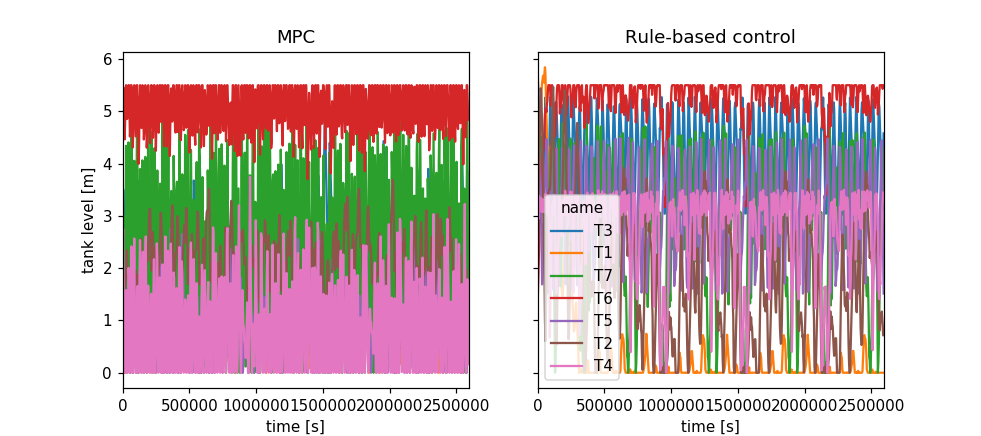

Text(0.5, 1.0, 'Rule-based control')

In [104]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize = (9,4))
results.node['pressure'][node_names[0]].plot(legend=False, ax=ax[0])
ref.node['pressure'][node_names[0]].plot(legend=True, ax=ax[1])

ax[0].set_ylabel('tank level [m]')
ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')

ax[0].set_title('MPC')
ax[1].set_title('Rule-based control')


# Energy

<IPython.core.display.Javascript object>


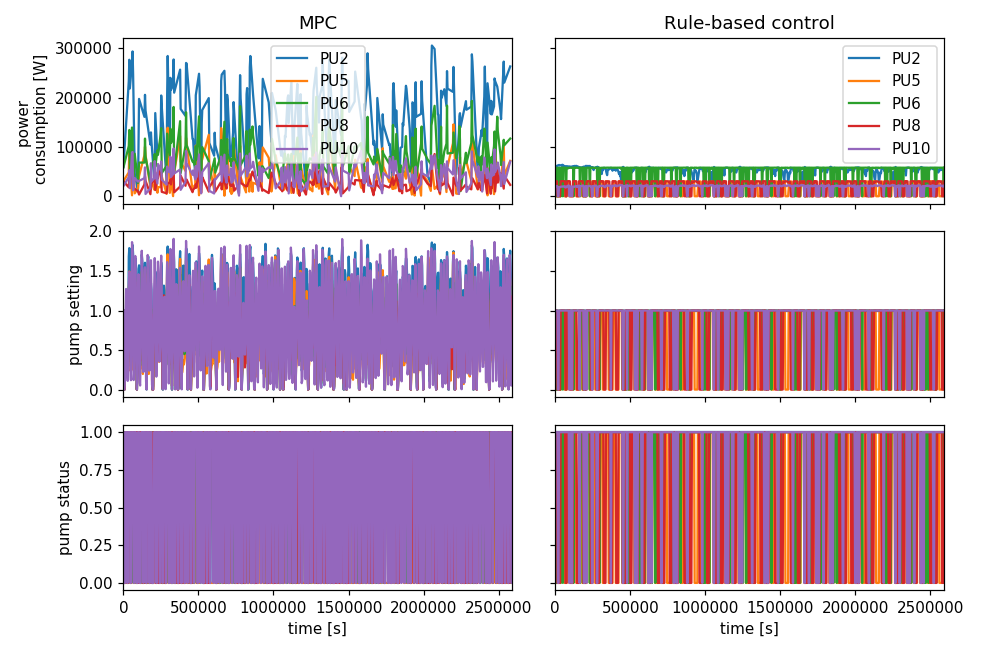

In [106]:
pump_power_mpc = economic.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_power_mpc = pump_power_mpc[(pump_power_mpc>0).all(axis=1)]

pump_power_rb = economic.pump_energy(ref.link['flowrate'], ref.node['head'], ctown.wn)[link_names[0]]
pump_power_rb = pump_power_rb[(pump_power_rb>=0).all(axis=1)]

fig, ax = plt.subplots(3,2, sharey='row', sharex=True, figsize = (9,6))
pump_power_mpc.plot(ax=ax[0,0])
pump_power_rb.plot(ax=ax[0,1])

results.link['setting'][link_names[0]].plot(ax=ax[1,0], legend=False)
ref.link['setting'][link_names[0]].plot(ax=ax[1,1], legend=False)

results.link['status'][link_names[0]].plot(ax=ax[2,0], legend=False)
ref.link['status'][link_names[0]].plot(ax=ax[2,1], legend=False)


ax[0,0].set_ylabel('power \n consumption [W]')
ax[1,0].set_ylabel('pump setting')
ax[2,0].set_ylabel('pump status')


ax[-1,0].set_xlabel('time [s]')
ax[-1,1].set_xlabel('time [s]')

ax[0,0].set_title('MPC')
ax[0,1].set_title('Rule-based control')

fig.tight_layout()

In [107]:
energy_mpc = np.sum(np.trapz(pump_power_mpc.to_numpy().T/1e3, dx=1))
energy_rb = np.sum(np.trapz(pump_power_rb.to_numpy().T/1e3, dx=1))

perc_diff = 100*(energy_rb-energy_mpc)/energy_rb

print('MPC power consumption:        {:.2f} kWh'.format(energy_mpc))
print('Rule-based power consumption: {:.2f} kWh'.format(energy_rb))
print('Power reduction: {:.2f}%'.format(perc_diff))

MPC power consumption:        83975.24 kWh
Rule-based power consumption: 109732.48 kWh
Power reduction: 23.47%


# Check if controls are actually implemented

In [135]:
from go_mpc import go_mpc
from casadi import *
from casadi.tools import *
import scipy.io as sio
n_horizon = 10
nn_model_path = './model/007_man_5x50_both_datasets_filtered_mpc02/'
nn_model_name = '007_man_5x50_both_datasets_filtered_mpc02'
cluster_labels = pd.read_json(nn_model_path+'cluster_labels_dt1h_both_datasets.json')
pressure_factor = pd.read_json(nn_model_path+'pressure_factor_dt1h_both_datasets.json')
gmpc = go_mpc(n_horizon, nn_model_path, nn_model_name, cluster_labels, pressure_factor, 0, 1)

data_path = './tempResults/'
mpc_res_full = sio.loadmat(data_path + '05_full_mpc_solution.mat')['x_mpc_full']

full_sol_cas = struct_symMX([
    entry('x', repeat=mpc_res_full.shape[0], struct = gmpc.obj_x)
])(0)
full_sol_cas['x'] = vertsplit(mpc_res_full) 


----------------------------------------------------
Loaded Keras model with the following architecture:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2350      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 42)                2142      
Total params: 12,142

<IPython.core.display.Javascript object>


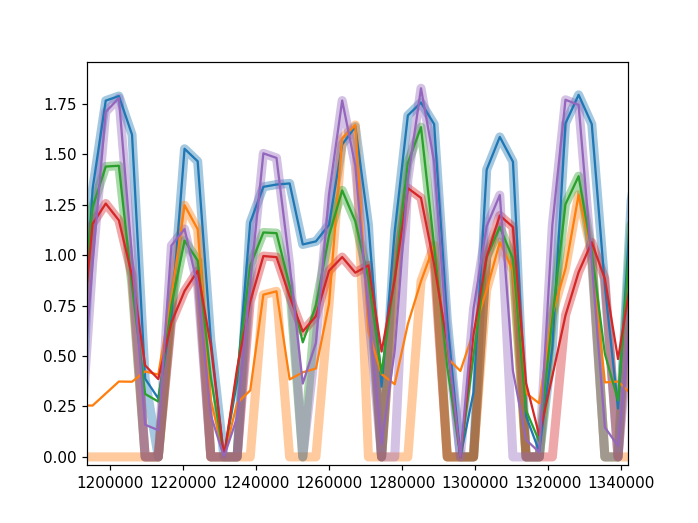

In [140]:
fig, ax = plt.subplots()

pump_speed_mpc = horzcat(*full_sol_cas['x',:,'u',0, 'head_pump']).T.full()
pump_speed_real = results.link['status'][link_names[0]].to_numpy()*results.link['setting'][link_names[0]]

pump_speed_real.plot(ax=ax, legend=False, linewidth=6, alpha=0.4)
ax.set_prop_cycle(None)
ax.plot(results.link['setting'].index, pump_speed_mpc)
plt.show()


# Check if clustering is still valid:

In [145]:
press_norm = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

jun_cl_press_group = press_norm.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press_group.mean()
jun_cl_press_std = jun_cl_press_group.std()

<IPython.core.display.Javascript object>


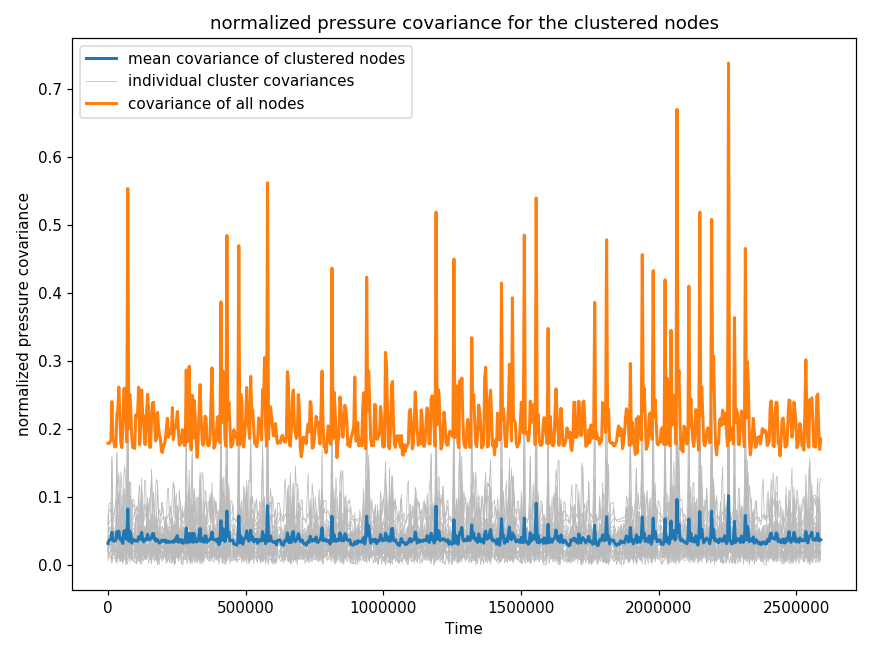

In [146]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_press_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_std.mean(axis=1), linewidth=2, alpha=1, label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


press_std_ges = press_norm.std(axis=1)
ax_2.plot(press_std_ges, linewidth=2, alpha=1, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized pressure covariance')
ax_2.set_title('normalized pressure covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()   

In [ ]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=4

ax_2.fill_between(jun_cl_press_mean.index,
                  (jun_cl_press_mean[[cluster_i]]-3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_press_mean[[cluster_i]]+3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.5, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_press_group.get_group(cluster_i),color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_press_mean[[cluster_i]], label='cluster mean')
ax_2.plot([0,0],[0,0], color='k', linewidth=0.2, alpha=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized pressure for cluster #{}  with n={} elements'.format(cluster_i, jun_cl_press_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('Pressure')